### **Step 1: Creating the BigQuery Dataset**

After creating the main GCP project `ml-ai-portfolio`, we navigated to the BigQuery Console to initialize the data storage layer for our forecasting project. Configuration:
- Dataset ID: taxi_forecasting
- Location: US
- Default Table Expiration: Never
- Description: Dataset for storing aggregated NYC taxi data and ML models.

At this stage, the dataset is empty and contains no tables yet.

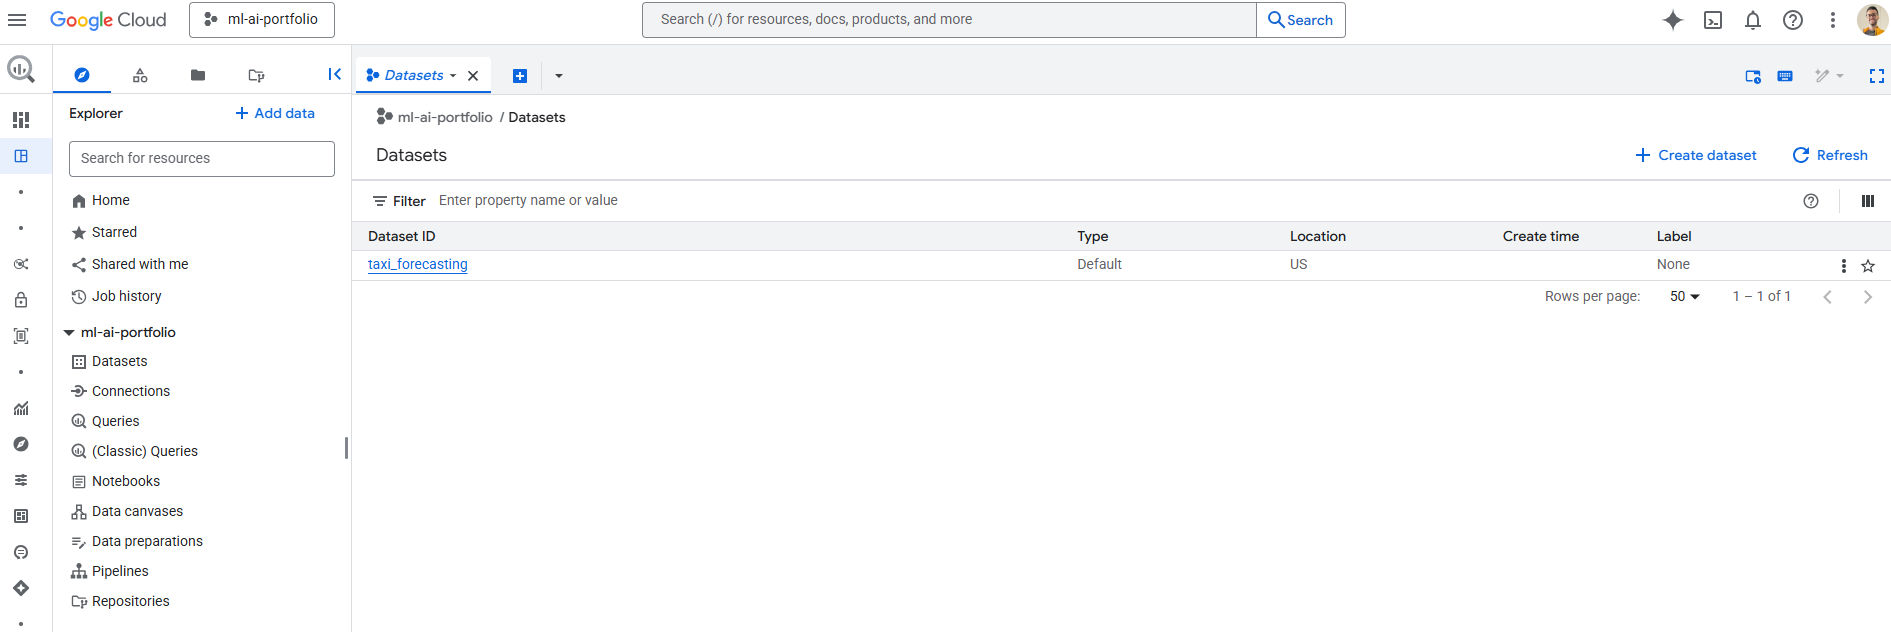

### **Step 2: Building the Daily Aggregated Taxi Trips Table**

Once the dataset taxi_forecasting was created, the next step was to prepare the raw NYC taxi trips data for time-series modeling.
Since forecasting models require regular time-indexed data, we aggregated the 2022 trip records into daily totals. We used the public dataset `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2022` and transformed the raw trip entries into a clean, daily time series.

In [ ]:
CREATE OR REPLACE TABLE
  `ml-ai-portfolio.taxi_forecasting.daily_2022` AS
SELECT
  DATE(pickup_datetime) AS trip_date,
  COUNT(*) AS total_trips
FROM 
  `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2022`
WHERE 
  pickup_datetime BETWEEN '2022-01-01' AND '2022-12-01'
GROUP BY 
  trip_date
ORDER BY 
  trip_date;

What This Query Does
- Extracts 2022 data from the public NYC taxi dataset
- Converts each trip’s timestamp into a date
- Groups all trips by day
- Counts the total number of trips for each day
- Stores the final results inside our dataset as a new table.

This aggregated table becomes the foundation for the entire forecasting project.

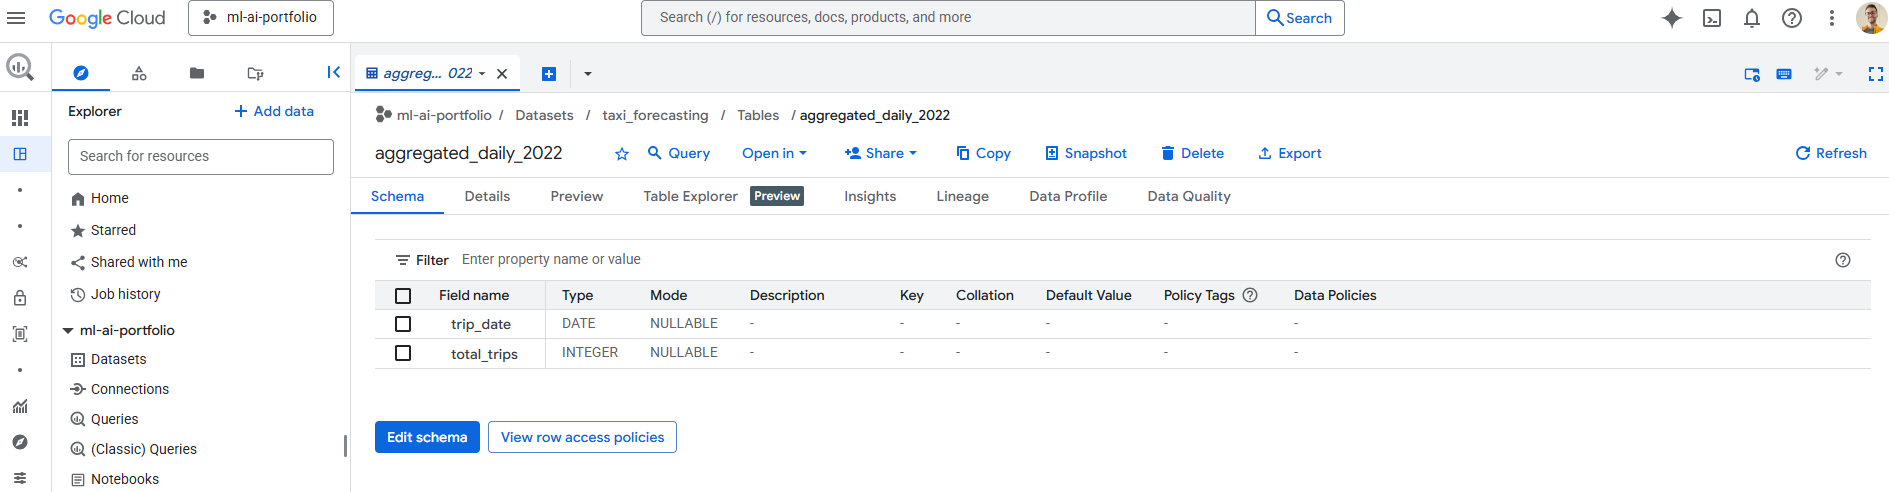

### **Step 3: Exploratory Data Analysis on the Aggregated Table**

After creating the daily aggregated table (daily_2022), we performed an initial exploratory analysis directly inside BigQuery.
The goal was to validate the structure of the dataset, inspect the date range, and confirm that our aggregation step worked correctly.

#### **3.1: Checking the Date Range and Number of Days**

To verify that the dataset covers the expected time period and contains one row per day, we executed the following SQL query:

In [ ]:
SELECT 
  MIN(trip_date), 
  MAX(trip_date), 
  COUNT(*) AS num_days
FROM `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`;

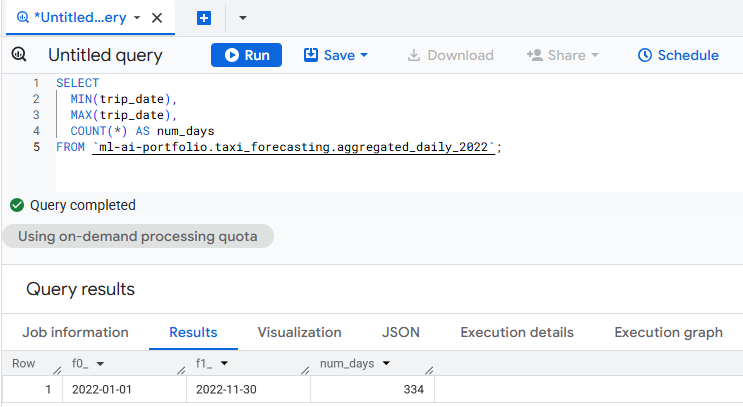

Interpretation is: 
- The dataset starts on January 1st, 2022
- It ends on November 30th, 2022
- There are 334 rows, which confirms:
- The aggregation was successful
- There is exactly one data point per day
- No missing dates within the range

#### **3.2: Analyzing Weekly Seasonality (Weekend Trips)**

To better understand the behavior of NYC taxi demand, we explored potential weekly patterns in the dataset. A common characteristic in transportation data is strong weekly seasonality—for example, higher demand on weekends compared to weekdays.

To investigate this, we extracted all Saturday and Sunday rows from the aggregated daily dataset using the following SQL query:

In [ ]:
SELECT
  trip_date,
  total_trips,
  FORMAT_DATE('%A', trip_date) AS weekday
FROM `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
WHERE FORMAT_DATE('%A', trip_date) IN ('Saturday' , 'Sunday')
ORDER BY trip_date;

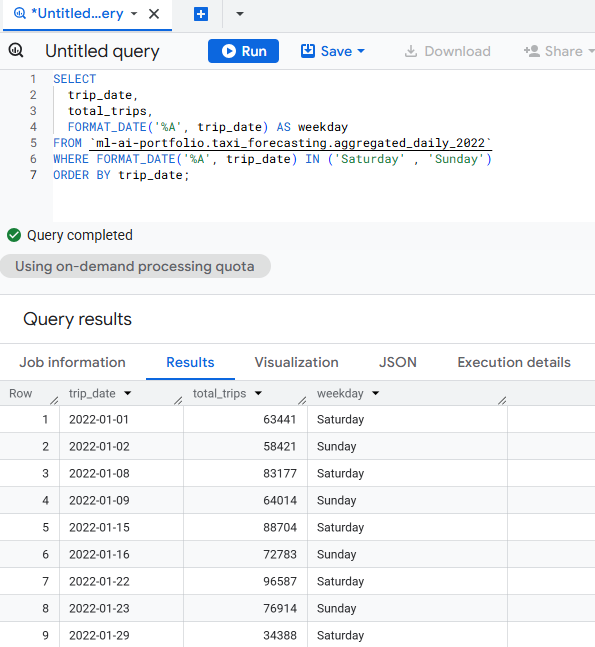

Interpretation is: 
- The table shows clear variations between weekends.
- Many Saturdays exhibit higher demand than Sundays.
- The irregular peaks correspond to NYC events, holidays, or winter weather patterns.
- This confirms that the dataset contains strong weekly seasonality, which is crucial for choosing the correct forecasting model.

These observations validate that ARIMA_PLUS (which automatically handles weekly seasonality) is an appropriate choice for our forecasting pipeline.

#### **3.3: Computing the Average Taxi Demand per Weekday**

To further explore the time-series characteristics of the dataset, we analyzed how taxi demand varies across different days of the week.
Understanding whether certain weekdays consistently show higher or lower activity helps validate:

In [ ]:
SELECT
  FORMAT_DATE('%A', trip_date) AS weekday,
  AVG(total_trips) AS avg_trips
FROM `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
GROUP BY weekday
ORDER BY avg_trips DESC;

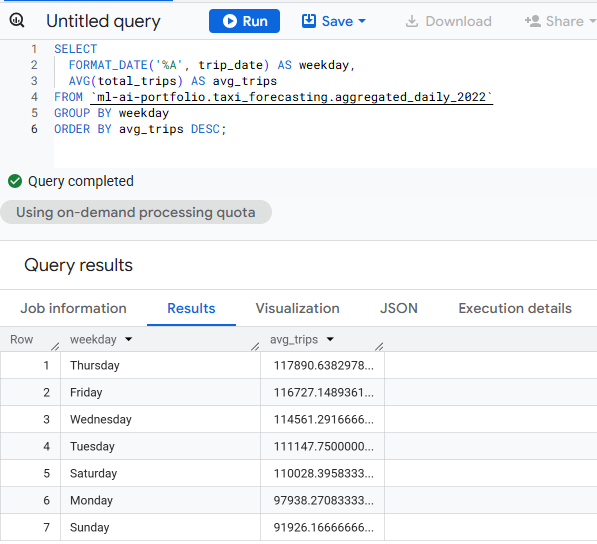

Interpretation is: 
- Thursday and Friday show the highest average demand — consistent with increased late-week activity in NYC.
- Monday and Sunday are the lowest activity days, indicating reduced movement at the start and end of the week.
- Strong weekly seasonality is clearly present:
    - High: Thu → Fri
    - Medium: Tue → Wed → Sat
    - Low: Mon → Sun

#### **3.4: Visualizing the Complete 2022 Time Series**

After aggregating the dataset into daily counts, we plotted the entire January–December 2022 daily trip volume. This visualization helps us understand the global behavior of the series before selecting a forecasting model.

In [ ]:
SELECT *
FROM `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
ORDER BY trip_date;

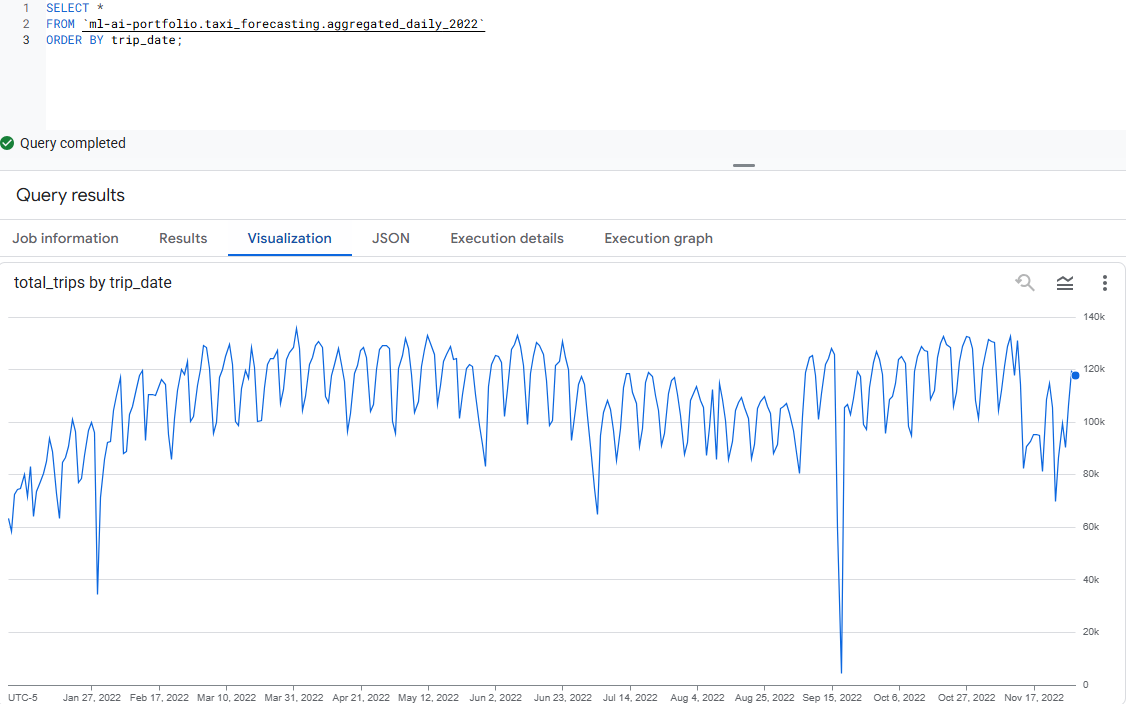

**1. Clear Weekly Seasonality**: The time-series shows a consistent zig-zag pattern, indicating strong weekly seasonality:

- Each week contains a peak (typically mid-week)
- And a drop (usually Saturday/Sunday)
- This repeating weekly cycle confirms that the dataset is ideal for a seasonal ARIMA (ARIMA_PLUS) model.

**2. Observable Long-Term Trends (Annual Trend)**: Several broader seasonal patterns are visible:

- January → April: Steady increase in demand
- Summer months: Slight decrease
- September & October: Strong rebound in demand
- Late November → December: Noticeable decline
- These trends confirm the dataset contains both long-term trend + seasonal patterns, making it a classic case for time-series forecasting.

**3. Presence of Outliers**: The chart highlights three strong dips:

- Late January
- Mid-July
- Mid-September (the most severe)

These outliers are typical in public mobility datasets and may be caused by:
- Severe weather
- Public holidays
- Under-reported or incomplete data for specific days

We do NOT remove these outliers. ARIMA_PLUS typically handles them internally, and removing them may distort the seasonality.

**4. Incomplete Data at the End of the Year**: The chart shows an abnormal drop at the end of November and early December. This indicates:

- The public dataset for December is not fully populated
- Only December 1st is complete
- The following days are missing or partially available
- Because of this, December should NOT be used as a test or training period.

Based on the insights:

- Training Range (January 1 → October 31)
- Test/Validation Range (November 1 → November 30)
- December (partially missing)
- Outliers (kept as-is; ARIMA handles them)
- Model Choice: ARIMA_PLUS (best suited for weekly seasonality + long-term trend)

### **Step 4: Building the ARIMA_PLUS Forecasting Model in BigQuery ML**

After completing exploratory analysis and deciding on the training and test ranges, the next step was to build the forecasting model using BigQuery ML. We used ARIMA_PLUS, Google’s advanced version of ARIMA that automatically handles:

- Trend and seasonality
- Holiday effects
- Outliers
- Auto ARIMA parameter selection
- Missing values

This makes it ideal for time-series datasets like NYC taxi demand.

In [ ]:
CREATE OR REPLACE MODEL `ml-ai-portfolio.taxi_forecasting.daily_arima_model`
OPTIONS(
  MODEL_TYPE = 'ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL = 'trip_date',
  TIME_SERIES_DATA_COL = 'total_trips',
  AUTO_ARIMA = TRUE,
  HOLIDAY_REGION = 'US'
) AS
SELECT
  trip_date,
  total_trips
FROM
  `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
WHERE
  trip_date BETWEEN '2022-01-01' AND '2022-10-31'  
ORDER BY
  trip_date;

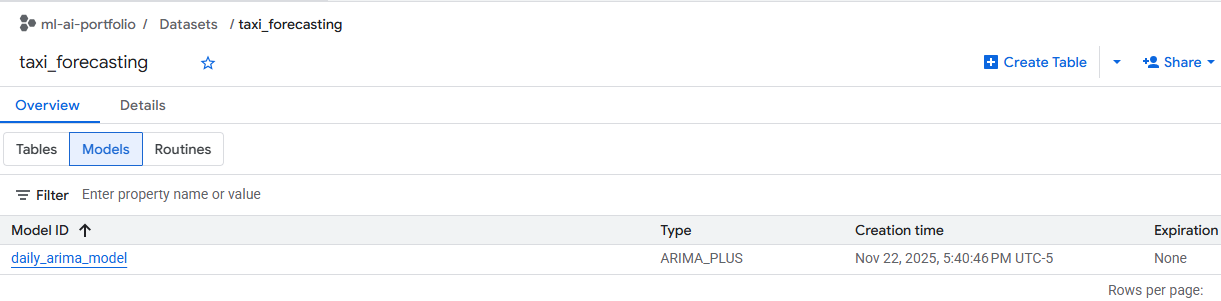

BigQuery automatically selects:

- p, d, q
- P, D, Q
- Seasonality type
- Holiday components
- Drift / spikes / anomalies

No manual tuning needed. Also, the model incorporates U.S. public holidays, which often affect transportation demand.

### **Step 5: Model Diagnostics Explanation**

After training the ARIMA-PLUS model in BigQuery ML, we inspected the diagnostic output using:

In [ ]:
SELECT *
FROM ML.EVALUATE(
  MODEL `ml-ai-portfolio.taxi_forecasting.daily_arima_model`
);

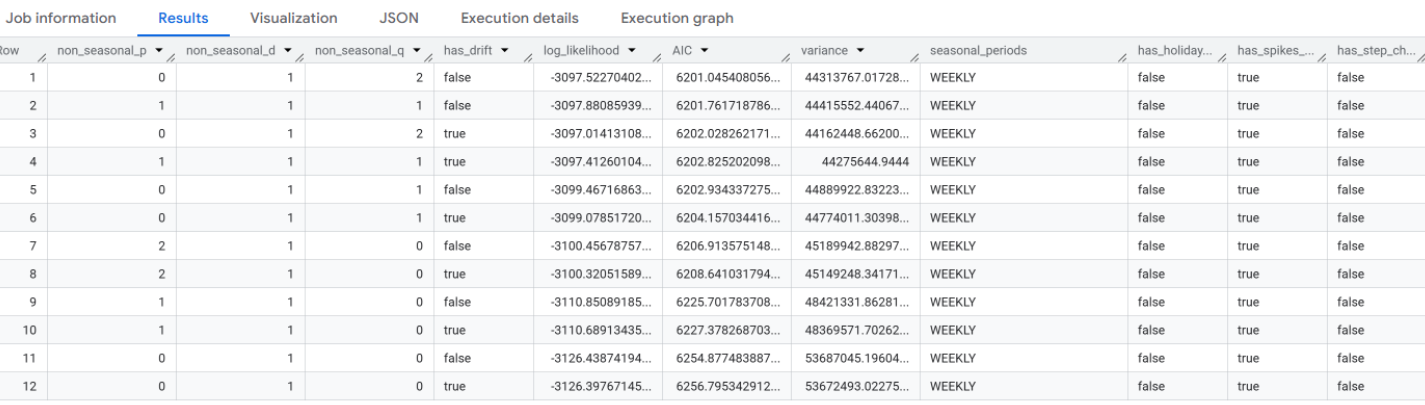

BigQuery returns multiple candidate ARIMA configurations. Each row in the table represents a different ARIMA model explored during the Auto-ARIMA search. Below is the explanation of the important columns.

**1. ARIMA Order (p, d, q)**: BigQuery tests several ARIMA configurations:

- p: Number of autoregressive (AR) terms
- d: Degree of differencing
- q: Number of moving average (MA) terms

Each row = a different ARIMA model. BigQuery ML automatically evaluates all combinations and chooses the configuration that best fits the time-series.

**2. has_drift**: Shows whether the model includes a drift term.

- TRUE → the model detected a long-term linear trend
- FALSE → no drift included

In our dataset (NYC taxi trips), a gradual trend exists, so TRUE is expected for some candidate models.

**3. log_likelihood**: Indicates how well the model fits the training data.

- Higher (less negative) = better fit
- Used internally for AIC calculation

**4. AIC (Akaike Information Criterion)**: The most important metric for ARIMA model selection.

- Lower AIC = better model
- Captures trade-off between:
- Goodness of fit
- Model complexity

During Auto-ARIMA search, BigQuery chooses the model with the lowest AIC among all

**5. has_spikes_and_dips**: Indicates whether the model detected irregular sudden spikes/drops.

- TRUE means the model accounts for:
- Holidays
- Weather events
- Unexpected dips
- Missing data anomalies
- Taxi trips data naturally has such fluctuations, so seeing TRUE is normal.

### **Step 6: Model Evaluation in BigQuery**

To evaluate how well the ARIMA+ model performs on unseen data, we created a comparison table for November 2022 where:

- Actual values come from the aggregated dataset (aggregated_daily_2022)
- Forecasted values come from BigQuery ML’s ML.FORECAST() function

Both datasets are merged to compute daily errors. This table is essential for computing metrics and visualizing model accuracy.

In [ ]:
CREATE OR REPLACE TABLE
  `ml-ai-portfolio.taxi_forecasting.actual_vs_forecast_nov2022` AS

WITH forecast AS (
  SELECT
    DATE(forecast_timestamp) AS forecast_date,
    forecast_value
  FROM
    ML.FORECAST(
      MODEL `ml-ai-portfolio.taxi_forecasting.daily_arima_model`,
      STRUCT(30 AS horizon)
    )
  WHERE
    forecast_timestamp BETWEEN '2022-11-01' AND '2022-11-30'
),

actual AS (
  SELECT
    trip_date AS actual_date,
    total_trips AS actual_value
  FROM
    `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
  WHERE
    trip_date BETWEEN '2022-11-01' AND '2022-11-30'
)

SELECT
  a.actual_date,
  a.actual_value,
  f.forecast_value,
  (a.actual_value - f.forecast_value) AS error,
  ABS(a.actual_value - f.forecast_value) AS abs_error
FROM actual a
JOIN forecast f
ON a.actual_date = f.forecast_date
ORDER BY actual_date;

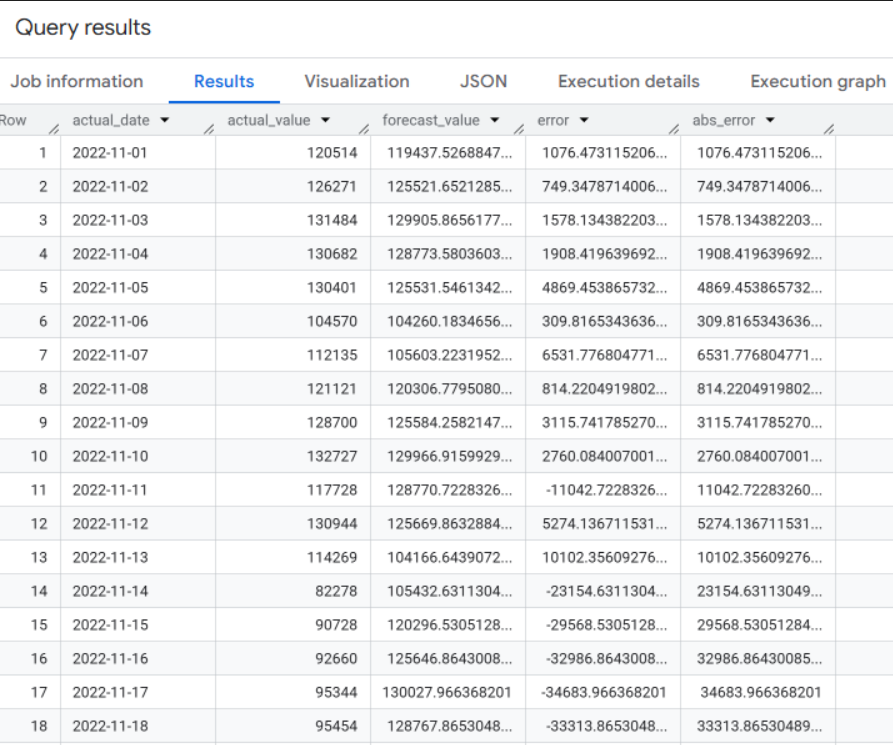

To understand how well the ARIMA+ model performed on the November 2022 unseen dataset, we computed three standard time-series error metrics using the actual_vs_forecast_nov2022 table created in the previous step.

In [ ]:
SELECT
  SQRT(AVG(POW(actual_value - forecast_value, 2))) AS RMSE,
  AVG(ABS(actual_value - forecast_value)) AS MAE,
  AVG(ABS((actual_value - forecast_value) / actual_value)) * 100 AS MAPE
FROM
  `ml-ai-portfolio.taxi_forecasting.actual_vs_forecast_nov2022`;

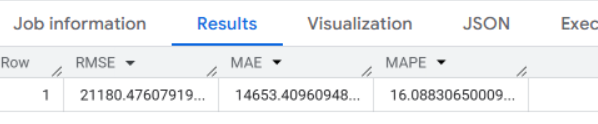

**1) Understanding the Scale of the Data**: Daily taxi trip counts for November ranged between:

- ~90,000 to ~135,000 trips per day
- With an average around 115,000

Because the dataset has a large numeric scale, absolute errors (MAE / RMSE) are less meaningful on their own — percentage-based metrics such as MAPE give a clearer picture of accuracy.

**2) MAPE – Most Important Metric for Time-Series**:

- MAPE ≈ 16%

On average, the model’s forecasts are 16% off from the true values. Given the natural volatility of NYC taxi data (weekly cycles, spikes, dips, holidays):

- < 10%	Good accuracy
- 10–20%	Moderate (acceptable baseline)
- 20%	Weak performance

Our model falls in the “moderate acceptable baseline” range.

**3) MAE – Average Absolute Error**:

- MAE ≈ 14,653 trips
- Relative to the ~115,000 daily average

This confirms the same conclusion as MAPE. The model has moderate accuracy, acceptable for a first baseline.


**4) RMSE – Penalizing Large Errors**: RMSE is always higher than MAE because it penalizes large errors more heavily.

- RMSE ≈ 21,180 trips
- strong weekly seasonality
- sharp dips
- occasional spikes
- holiday effects

An RMSE around ~18% of mean daily trips indicates. The model struggles on extreme days (spikes/dips), but performs reasonably otherwise.

### **Step 7: Setting Up the Python Environment**

This step prepares the project for running Python scripts that interact with BigQuery ML, generate forecasts, and visualize results.. Inside the project directory (project01-bq-ml-forecasting), create a new Python virtual environment:

In [5]:
python -m venv venv

venv\Scripts\activate


SyntaxError: invalid syntax (3360359193.py, line 1)

### **Step 8: Authentication and Project Configuration**

This creates a folder named venv/ that will contain all isolated Python dependencies for this project. All work is done locally on your machine, using a dedicated virtual environment and a requirements.txt file. Install all required packages using the requirements.txt file:

In [ ]:
pip install -r requirements.txt

- google-cloud-bigquery
- db-dtypes
- pandas
- numpy
- matplotlib
- google-auth
- google-cloud-bigquery-storage

### **Step 8: Authentication and Project Configuration**

Before running any Python scripts that interact with BigQuery, it is required to authenticate the local environment and ensure that the correct Google Cloud project is active.

List all authenticated accounts on your machine:

In [ ]:
gcloud auth list

This displays all accounts previously authenticated via gcloud. If the active account is not the one used for this project, switch or re-authenticate in the next steps.

If you want to clear any previously stored Application Default Credentials (ADC):

In [ ]:
gcloud auth application-default revoke

Authenticate with the correct Google account:

In [ ]:
gcloud auth login

Specify the Google Cloud project this ML pipeline belongs to:

In [ ]:
gcloud config set project ml-ai-portfolio

Check that the project is correctly set:

gcloud config list project

### **Step 9: Building a Reusable BigQuery Client in Python**

To interact with BigQuery from Python, we created a dedicated helper class named BigQueryClient.
This class provides two essential functions:

- Executing SQL queries
- Returning results as Pandas DataFrames

In [ ]:
from google.cloud import bigquery

class BigQueryClient:
    def __init__(self):
        self.client = bigquery.Client()

    def run_query(self, query: str):
        try:
            query_job = self.client.query(query)
            return query_job.result()
        except Exception as e:
            print(f"Error running query: {e}")
            return None

    def to_dataframe(self, query: str):
        try:
            df = self.client.query(query).to_dataframe()
            return df
        except Exception as e:
            print(f"Error converting query result to DataFrame: {e}")
            return None

This class abstracts away BigQuery boilerplate code.
It provides a clean, simple API for querying BigQuery from within Python scripts used later in the project.

- Centralized BigQuery access logic
- Automatically uses your ADC credentials
- Support SQL execution (RowIterator)
- Support DataFrame output for analysis & plotting
- Clean error handling

### **Step 10: Building the Model Predictor**

After creating the reusable BigQueryClient, the next step was to build a component that interacts directly with the trained ARIMA+ model stored in BigQuery ML. We created a class named ModelPredictor, whose responsibility is:

- Calling ML.FORECAST from BigQuery
- Retrieving predictions as a Pandas DataFrame
- Supporting forecast horizons of any length (e.g., 30, 60, 90 days)

This module is essential for enabling Python-based forecasting and future

In [ ]:
from bq_client import BigQueryClient

class ModelPredictor:
    def __init__(self):
        self.bq = BigQueryClient()

    def forecast_next_days(self, model_full_path: str, days: int = 30):
        query = f"""
        SELECT
          forecast_timestamp,
          forecast_value
        FROM
          ML.FORECAST(
            MODEL `{model_full_path}`,
            STRUCT({days} AS horizon)
          )
        """

        df = self.bq.to_dataframe(query)
        return df

### **Step 11: Python Evaluation: Actual vs Forecast Plot for November**

After building the ARIMA+ model in BigQuery ML and generating the November forecast values, we performed a Python-based evaluation to visually compare:

- Actual daily trips vs
- Model-predicted daily trips

This step provides a clear visual understanding of model performance and highlights where the model is accurate or deviates.

In [ ]:
from bq_client import BigQueryClient
from model_predict import ModelPredictor
import pandas as pd
import matplotlib.pyplot as plt

# ================================
# 1) Load Actual November Data
# ================================
def get_actual_november():
    bq = BigQueryClient()

    query = """
    SELECT
      trip_date AS actual_date,
      total_trips AS actual_value
    FROM
      `ml-ai-portfolio.taxi_forecasting.aggregated_daily_2022`
    WHERE
      trip_date BETWEEN '2022-11-01' AND '2022-11-30'
    ORDER BY actual_date;
    """

    df = bq.to_dataframe(query)
    return df


# ================================
# 2) Load Forecast November Data
# ================================
def get_forecast_november():
    predictor = ModelPredictor()

    df = predictor.forecast_next_days(
        model_full_path="ml-ai-portfolio.taxi_forecasting.daily_arima_model",
        days=30
    )

    df["forecast_date"] = df["forecast_timestamp"].dt.date
    df = df[["forecast_date", "forecast_value"]]

    return df


# ================================
# 3) Merge Actual and Forecast
# ================================
def merge_actual_forecast(actual_df, forecast_df):
    actual_df["actual_date"] = pd.to_datetime(actual_df["actual_date"])
    forecast_df["forecast_date"] = pd.to_datetime(forecast_df["forecast_date"])

    merged = pd.merge(
        actual_df,
        forecast_df,
        left_on="actual_date",
        right_on="forecast_date",
        how="inner"
    )

    return merged


# ================================
# 4) Plot Actual vs Forecast
# ================================
def plot_actual_vs_forecast(merged):
    plt.figure(figsize=(14, 6))
    
    plt.plot(merged["actual_date"], merged["actual_value"], label="Actual", marker="o")
    plt.plot(merged["forecast_date"], merged["forecast_value"], label="Forecast", marker="x")
    
    plt.title("Actual vs Forecast - November 2022")
    plt.xlabel("Date")
    plt.ylabel("Daily Trips")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ================================
# 5) MAIN
# ================================
if __name__ == "__main__":
    actual = get_actual_november()
    forecast = get_forecast_november()

    merged = merge_actual_forecast(actual, forecast)

    print(merged.head())
    print(merged.tail())

    plot_actual_vs_forecast(merged)

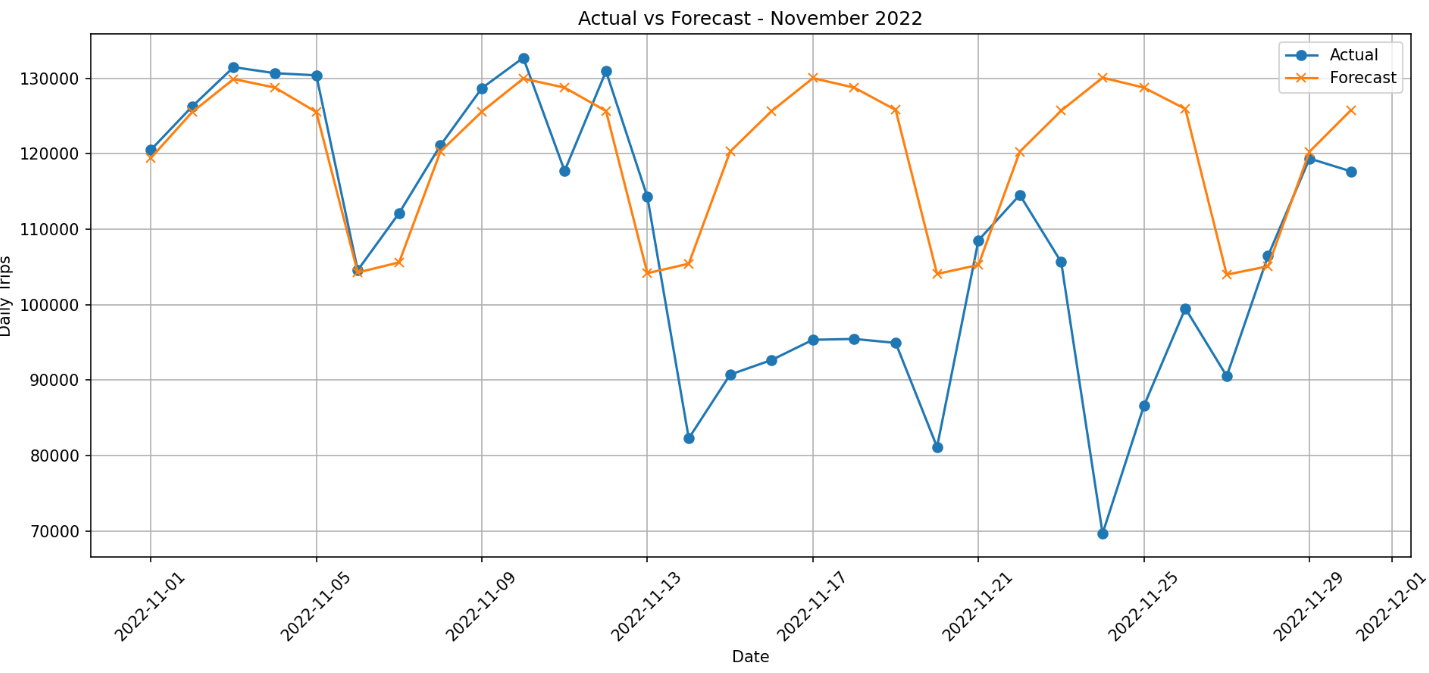

**1. Actual Values Contain Sharp Dips**: Certain days—such as November 12 and 23—show unusually steep drops in actual taxi demand.
These are typically caused by:

- Holiday effects
- Extreme weather
- Under-reported data
- Event-driven anomalies

**2. Forecast Line is Smoother**:

ARIMA+ tends to generate smoothed predictions and does not fully capture the extreme dips. This behavior is normal for ARIMA-style models.

**3. Forecast Errors Increase in the Second Half of November**:

- The model begins to diverge more noticeably in mid-to-late November.
- The model was trained only through October 31,
- But November has its own distinct seasonal behaviors, especially around holidays.

The model is following the October trend, while November deviates more sharply.

### **Step 12: Forecasting December 2022 (Future Unseen Data)**

After validating the model's performance on November 2022, the final step is to generate predictions for a future month that the model has never seen: December 2022.

Because our ARIMA+ model was trained only until October 31, 2022, forecasting December represents a real-world scenario of predicting future unseen data beyond the training horizon.

In [ ]:
from model_predict import ModelPredictor
import pandas as pd

predictor = ModelPredictor()

# Predict next 60 days
df = predictor.forecast_next_days(
    model_full_path="ml-ai-portfolio.taxi_forecasting.daily_arima_model",
    days=61
)

#Convert to datetime formar
df["forecast_date"] = df["forecast_timestamp"].dt.date

december_df = df[
    (df["forecast_date"] >= pd.to_datetime("2022-12-01").date()) &
    (df["forecast_date"] <= pd.to_datetime("2022-12-31").date())
]

print(december_df)

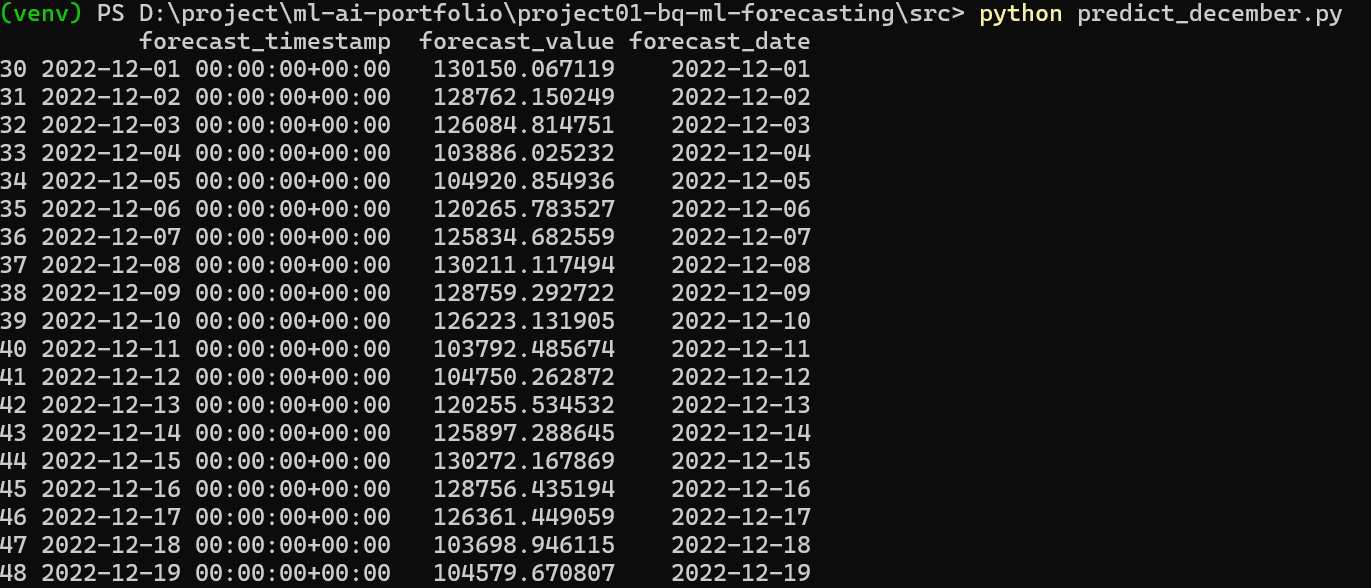